In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# -*- coding: utf-8 -*-
"""
Best Model Pipeline for TAR + GCN with Joint Improvements

This code implements:
  - A TAR module that uses both a supervised head and a contextual loss.
  - A GCN module that leverages a Chebyshev convolution architecture.
  - Separate training for TAR and GCN, with options for joint fine-tuning.

Adjust the hyperparameters below as needed.
"""

import os, pickle
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [3]:
def get_multi_labels(ratings, threshold=5):
    """Convert ratings into binary labels for [arousal, valence, dominance]."""
    arousal   = 1 if ratings[0] > threshold else 0
    valence   = 1 if ratings[1] > threshold else 0
    dominance = 1 if ratings[2] > threshold else 0
    return [arousal, valence, dominance]


class DEAPMultiLabelDataset(Dataset):
    def __init__(self, data_dir, subject_list, transform=None, threshold=5):
        self.data = []   # (eeg_trial, multi-label vector)
        self.transform = transform
        self.threshold = threshold

        for subj in subject_list:
            fname = f"s{subj:02d}.dat"
            file_path = os.path.join(data_dir, fname)
            if not os.path.exists(file_path):
                print(f"Warning: {file_path} not found.")
                continue

            with open(file_path, 'rb') as f:
                subj_data = pickle.load(f, encoding='latin1')
                eeg_trials = subj_data['data']    # shape: (trials, channels, signal_length)
                labels     = subj_data['labels']    # shape: (trials, num_ratings)
                for trial, lab in zip(eeg_trials, labels):
                    multi_label = get_multi_labels(lab, threshold=self.threshold)
                    self.data.append((trial, multi_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eeg_trial, label = self.data[idx]
        if self.transform:
            eeg_trial = self.transform(eeg_trial)
        return eeg_trial, torch.tensor(label, dtype=torch.float)


def welch_spectral_features(signal_data, fs=128, freq_band=(4,45), nperseg=128):
    f, Pxx = signal.welch(signal_data, fs=fs, nperseg=nperseg)
    idx = np.where((f >= freq_band[0]) & (f <= freq_band[1]))[0]
    return Pxx[idx]  # 1-D vector


def extract_spatial_spectral(eeg_trial, mapping_matrix, fs=128):
    C = eeg_trial.shape[0]
    spectral_features = []
    for ch in range(C):
        feat = welch_spectral_features(eeg_trial[ch, :], fs=fs)
        spectral_features.append(feat)
    spectral_features = np.array(spectral_features)  # shape: (C, B)

    P, Q = mapping_matrix.shape
    B = spectral_features.shape[1]
    feature_map = np.zeros((P, Q, B), dtype=np.float32)
    for i in range(P):
        for j in range(Q):
            ch_idx = mapping_matrix[i, j]
            if 0 <= ch_idx < C:
                feature_map[i, j, :] = spectral_features[ch_idx, :]
    return feature_map


class SpatialSpectralTransform:
    def __init__(self, mapping_matrix, fs=128):
        self.mapping_matrix = mapping_matrix
        self.fs = fs

    def __call__(self, eeg_trial):
        feat = extract_spatial_spectral(eeg_trial, self.mapping_matrix, fs=self.fs)
        # Rearrange to (B, P, Q) for CNN input.
        feat = np.transpose(feat, (2, 0, 1))
        return torch.from_numpy(feat)


# Build mapping matrix for 32 channels in a 4 x 8 grid.
P, Q = 4, 8
mapping_matrix = -1 * np.ones((P, Q), dtype=np.int32)
channels = list(range(32))
for idx, ch in enumerate(channels):
    i = idx // Q
    j = idx % Q
    mapping_matrix[i, j] = ch

In [4]:

# 2. TAR_Transformer: CNN + Transformer with Supervised Head

class TAR_Transformer(nn.Module):
    def __init__(self, in_channels, out_features=128, num_heads=4, num_layers=2, num_classes=3):

        super(TAR_Transformer, self).__init__()

        # CNN part
        self.conv1a = nn.Conv2d(in_channels, 42, kernel_size=2, stride=1)
        self.conv1b = nn.Conv2d(in_channels, 42, kernel_size=2, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(42, 128, kernel_size=2, stride=2)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128, nhead=num_heads,
            dim_feedforward=256, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(128, out_features)
        self.classifier = nn.Linear(out_features, num_classes)

    def forward(self, x):
        out = self.conv1a(x) + self.conv1b(x)
        out = self.pool(out)
        out = self.conv2(out)
        out = F.relu(out)

        batch_size, channels, p, q = out.shape
        seq_len = p * q
        out = out.permute(0, 2, 3, 1).reshape(batch_size, seq_len, 128)

        out = self.transformer(out)
        emb = self.fc(out.mean(dim=1))
        logits = self.classifier(emb)
        return emb, logits



In [5]:

# 3. Loss Functions for TAR & Graph Construction


def compute_contextual_loss(features, h=0.1):
    batch_size = features.size(0)
    normed = F.normalize(features, p=2, dim=1)
    sim_matrix = torch.matmul(normed, normed.t())
    d_matrix = 1 - sim_matrix
    d_matrix_no_diag = d_matrix + torch.eye(batch_size, device=features.device)*1e6
    d_min, _ = torch.min(d_matrix_no_diag, dim=1, keepdim=True)
    d_tilde = d_matrix / (d_min + 1e-5)
    omega = torch.exp((1 - d_tilde) / h)
    max_per_col, _ = torch.max(omega, dim=0, keepdim=True)
    Z = omega / (max_per_col + 1e-5)
    Lz = -torch.log(Z.mean() + 1e-5)
    return Lz

def compute_adjacency_loss(Lz, R_star, gamma=1.3):
    diff = torch.abs(Lz - R_star)
    return gamma ** diff



In [6]:

# 4. GCN Module: Chebyshev-based Graph Convolution and Multi-Task GCN


class ChebConv(nn.Module):
    def __init__(self, in_features, out_features, K, lambda_max=2):
        super(ChebConv, self).__init__()
        self.K = K
        self.theta = nn.Parameter(torch.Tensor(K+1, in_features, out_features))
        nn.init.xavier_uniform_(self.theta)

    def forward(self, X, L):
        N = X.size(0)
        L_tilde = (2.0 / 2) * L - torch.eye(N, device=X.device)  # lambda_max approximated as 2
        T_k = [torch.eye(N, device=X.device), L_tilde]
        for k in range(2, self.K+1):
            T_k.append(2 * torch.mm(L_tilde, T_k[-1]) - T_k[-2])
        out = 0
        for k in range(self.K+1):
            out += torch.mm(T_k[k], X) @ self.theta[k]
        return out

class GCN_MultiTask(nn.Module):
    def __init__(self, in_features, hidden_features=128, out_features=3, K=3):
        super(GCN_MultiTask, self).__init__()
        self.conv1 = ChebConv(in_features, hidden_features, K)
        self.conv2 = ChebConv(hidden_features, out_features, K)

    def forward(self, X, L):
        x = F.relu(self.conv1(X, L))
        x = self.conv2(x, L)  # (N, 3) logits
        return x

def compute_normalized_laplacian(A):
    d = torch.sum(A, dim=1)
    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(d + 1e-5))
    L = torch.eye(A.size(0), device=A.device) - D_inv_sqrt @ A @ D_inv_sqrt
    return L


In [7]:

# 5. Training Functions for TAR and GCN


def train_tar(tar_model, dataloader, num_epochs=20, lr=5e-4, alpha=0.6, beta=0.4):
    """
    Trains TAR with a combined loss:
      L_total = alpha * L_supervised + beta * L_contextual.
    """
    tar_model.train()
    optimizer = optim.Adam(tar_model.parameters(), lr=lr)
    cls_loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            optimizer.zero_grad()
            emb, logits = tar_model(inputs)
            supervised_loss = cls_loss_fn(logits, labels)
            contextual_loss = compute_contextual_loss(emb)
            total_loss = alpha * supervised_loss + beta * contextual_loss
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()
        print(f"TAR Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")
    return tar_model

def predict_adjacency(tar_model, dataloader, h=0.1, threshold=0.5):
    tar_model.eval()
    emb_list = []
    label_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            emb, _ = tar_model(inputs)
            emb_list.append(emb)
            label_list.append(labels.to(device))
    features_all = torch.cat(emb_list, dim=0)
    labels_all = torch.cat(label_list, dim=0)

    normed = F.normalize(features_all, p=2, dim=1)
    sim_matrix = torch.matmul(normed, normed.t())
    d_matrix = 1 - sim_matrix
    d_matrix_no_diag = d_matrix + torch.eye(d_matrix.size(0), device=device)*1e6
    d_min, _ = torch.min(d_matrix_no_diag, dim=1, keepdim=True)
    d_tilde = d_matrix / (d_min + 1e-5)
    omega = torch.exp((1 - d_tilde)/h)
    max_per_col, _ = torch.max(omega, dim=0, keepdim=True)
    Z = omega / (max_per_col + 1e-5)
    A_pred = (Z > np.exp((1 - threshold)/h)).float()


    plt.title("Predicted Adjacency Matrix")


    return A_pred.to(device), labels_all, features_all

def train_gcn_multitask(gcn_model, features, A, labels, num_epochs=200, lr=2e-4, weight_decay=1e-4,model_path="/content/drive/My Drive/models/tardgcn_model13.pth"):
    gcn_model.train()
    optimizer = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)
    L = compute_normalized_laplacian(A)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = gcn_model(features, L)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        with torch.no_grad():
            preds = (torch.sigmoid(output) > 0.5).float()
            acc = (preds == labels).float().mean().item() * 100
            logits_mean = output.mean().item()
            logits_std = output.std().item()
        if (epoch+1) % 10 == 0:
            print(f"GCN Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.2f}%")
            # print(f"  Logits: mean={logits_mean:.4f}, std={logits_std:.4f}")
    torch.save(gcn_model.state_dict(), model_path)
    print(f"Model saved to Google Drive at {model_path}")
    return gcn_model

Starting TAR training with combined loss...
TAR Epoch 1/10, Loss: 1.4602
TAR Epoch 2/10, Loss: 1.4534
TAR Epoch 3/10, Loss: 1.4481
TAR Epoch 4/10, Loss: 1.4432
TAR Epoch 5/10, Loss: 1.4427
TAR Epoch 6/10, Loss: 1.4417
TAR Epoch 7/10, Loss: 1.4388
TAR Epoch 8/10, Loss: 1.4389
TAR Epoch 9/10, Loss: 1.4426
TAR Epoch 10/10, Loss: 1.4358
Predicting adjacency using TAR features...
Starting GCN training...
GCN Epoch 10/200, Loss: 0.6186, Accuracy: 70.50%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


GCN Epoch 20/200, Loss: 0.5681, Accuracy: 71.13%
GCN Epoch 30/200, Loss: 0.5448, Accuracy: 72.93%
GCN Epoch 40/200, Loss: 0.5369, Accuracy: 73.33%
GCN Epoch 50/200, Loss: 0.5338, Accuracy: 73.53%
GCN Epoch 60/200, Loss: 0.5323, Accuracy: 73.67%
GCN Epoch 70/200, Loss: 0.5313, Accuracy: 73.70%
GCN Epoch 80/200, Loss: 0.5305, Accuracy: 73.73%
GCN Epoch 90/200, Loss: 0.5298, Accuracy: 73.87%
GCN Epoch 100/200, Loss: 0.5292, Accuracy: 73.97%
GCN Epoch 110/200, Loss: 0.5287, Accuracy: 73.93%
GCN Epoch 120/200, Loss: 0.5282, Accuracy: 74.10%
GCN Epoch 130/200, Loss: 0.5276, Accuracy: 74.20%
GCN Epoch 140/200, Loss: 0.5271, Accuracy: 74.23%
GCN Epoch 150/200, Loss: 0.5266, Accuracy: 74.27%
GCN Epoch 160/200, Loss: 0.5260, Accuracy: 74.30%
GCN Epoch 170/200, Loss: 0.5255, Accuracy: 74.40%
GCN Epoch 180/200, Loss: 0.5249, Accuracy: 74.40%
GCN Epoch 190/200, Loss: 0.5243, Accuracy: 74.53%
GCN Epoch 200/200, Loss: 0.5237, Accuracy: 74.53%
Model saved to Google Drive at /content/drive/My Drive/mod

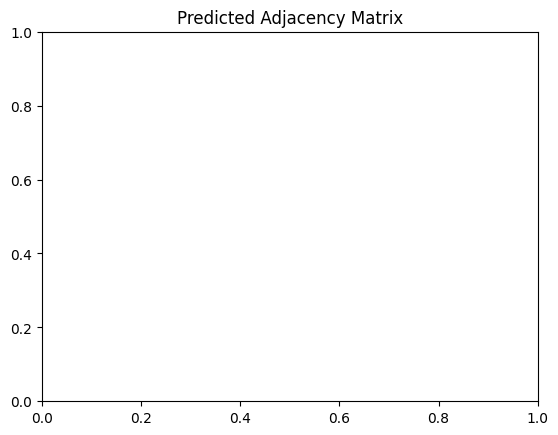

In [8]:

# 6. Main Execution: Data Loading, Training, and Testing


if __name__ == '__main__':
    data_dir = '/content/drive/MyDrive/deap_dataset'
    train_subjects = list(range(1, 26))
    test_subjects  = list(range(26, 33))

    transform = SpatialSpectralTransform(mapping_matrix, fs=128)
    train_dataset = DEAPMultiLabelDataset(data_dir=data_dir, subject_list=train_subjects, transform=transform)
    test_dataset  = DEAPMultiLabelDataset(data_dir=data_dir, subject_list=test_subjects, transform=transform)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize TAR module.
    sample_eeg, _ = train_dataset[0]
    in_channels = sample_eeg.shape[0]
    tar_model = TAR_Transformer(in_channels=in_channels, out_features=128, num_heads=4, num_layers=2, num_classes=3).to(device)

    print("Starting TAR training with combined loss...")
    tar_model = train_tar(tar_model, train_loader, num_epochs=10, lr=5e-4, alpha=0.6, beta=0.4)

    print("Predicting adjacency using TAR features...")
    A_hat, train_labels, train_features = predict_adjacency(tar_model, train_loader)

    # Train GCN with improved settings.
    gcn_model = GCN_MultiTask(in_features=128, hidden_features=128, out_features=3, K=3).to(device)
    print("Starting GCN training...")
    gcn_model = train_gcn_multitask(gcn_model, train_features, A_hat, train_labels, num_epochs=200, lr=2e-4, weight_decay=1e-4,model_path="/content/drive/My Drive/models/tardgcn_model13.pth")

    # Testing Phase.
    tar_model.eval()
    test_emb_list = []
    test_label_list = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            emb, _ = tar_model(inputs)
            test_emb_list.append(emb)
            test_label_list.append(labels.to(device))
    test_features = torch.cat(test_emb_list, dim=0)
    test_labels = torch.cat(test_label_list, dim=0)

    N_test = test_features.size(0)
    L_test = torch.eye(N_test, device=device)

    gcn_model.eval()
    with torch.no_grad():
        output_test = gcn_model(test_features, L_test)
        probs = torch.sigmoid(output_test)
        preds = (probs > 0.5).float()

    correct = (preds == test_labels).float()
    acc_per_dim = correct.mean(dim=0) * 100
    print("Test Accuracy (in %):")
    print(f"  Arousal: {acc_per_dim[0].item():.2f}%")
    print(f"  Valence: {acc_per_dim[1].item():.2f}%")
    print(f"  Dominance: {acc_per_dim[2].item():.2f}%")


    # (Optional) Joint Fine-Tuning of TAR and GCN

    joint_params = list(tar_model.parameters()) + list(gcn_model.parameters())
    joint_optimizer = optim.Adam(joint_params, lr=1e-4, weight_decay=1e-4)
    num_joint_epochs = 20
    for epoch in range(num_joint_epochs):
        tar_model.train()
        gcn_model.train()
        joint_optimizer.zero_grad()
        emb_list, label_list = [], []
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            emb, _ = tar_model(inputs)
            emb_list.append(emb)
            label_list.append(labels)
        features_joint = torch.cat(emb_list, dim=0)
        labels_joint = torch.cat(label_list, dim=0)
        A_joint, _, _ = predict_adjacency(tar_model, train_loader)
        L_joint = compute_normalized_laplacian(A_joint)
        output_joint = gcn_model(features_joint, L_joint)
        joint_loss = nn.BCEWithLogitsLoss()(output_joint, labels_joint)
        joint_loss.backward()
        joint_optimizer.step()
        if (epoch+1) % 10 == 0:
            preds_joint = (torch.sigmoid(output_joint) > 0.5).float()
            acc_joint = (preds_joint == labels_joint).float().mean().item() * 100
            print(f"Joint Epoch {epoch+1}/{num_joint_epochs}, Loss: {joint_loss.item():.4f}, Accuracy: {acc_joint:.2f}%")


In [9]:
def map_emotion(predicted_label):

    if isinstance(predicted_label, torch.Tensor):
        predicted_label = predicted_label.tolist()

    arousal, valence, dominance = int(predicted_label[0]), int(predicted_label[1]), int(predicted_label[2])

    if arousal == 1 and valence == 1:
        emotion = "Happy/Excited"
    elif arousal == 1 and valence == 0:
        emotion = "Angry/Agitated"
    elif arousal == 0 and valence == 1:
        emotion = "Calm/Relaxed"
    else:  # arousal == 0 and valence == 0
        emotion = "Sad/Melancholic"

    if dominance == 1:
        dominance_desc = "with confidence"
    else:
        dominance_desc = "with less control"

    return f"{emotion} {dominance_desc}"


In [10]:

gcn_model_path = "/content/drive/My Drive/models/tardgcn_model13.pth"

gcn_model = GCN_MultiTask(in_features=128, hidden_features=128, out_features=3, K=3).to(device)

gcn_model.load_state_dict(torch.load(gcn_model_path, map_location=device))
gcn_model.eval()


# Prediction Function Using Loaded GCN Model

def predict_sample(tar_model, gcn_model, dataset, index, device):


    tar_model.eval()
    gcn_model.eval()

    sample, original_label = dataset[index]

    sample = sample.unsqueeze(0).to(device).float()

    with torch.no_grad():

        emb, _ = tar_model(sample)
        L_identity = torch.eye(emb.size(0), device=device)
        gcn_output = gcn_model(emb, L_identity)
        probs = torch.sigmoid(gcn_output)
        pred_label = (probs > 0.5).float().squeeze(0)

    return original_label, pred_label




<ipython-input-10-a5f0a91e0a4c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load(gcn_model_path, map_location=device))



--- Prediction on Individual Test Samples ---

Sample index 201:
  Original Label : [0.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Sad/Melancholic with confidence
Predicted Mapped Emotion: Sad/Melancholic with confidence


Sample index 202:
  Original Label : [0.0, 0.0, 0.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Sad/Melancholic with less control
Predicted Mapped Emotion: Sad/Melancholic with confidence


Sample index 203:
  Original Label : [0.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Sad/Melancholic with confidence
Predicted Mapped Emotion: Sad/Melancholic with confidence


Sample index 204:
  Original Label : [1.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Angry/Agitated with confidence
Predicted Mapped Emotion: Sad/Melancholic with confidence


Sample index 205:
  Original Label : [0.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Sad/Mela

In [19]:
# Predict and Print Outputs for Samples

print("\n--- Prediction on Individual Test Samples ---\n")
num_samples_to_predict = 5
for i in range(45,75):
    orig_label, prediction = predict_sample(tar_model, gcn_model, test_dataset, i, device)
    orig_list = orig_label.tolist()
    pred_list = prediction.tolist()
    print(f"Sample index {i+1}:")
    print(f"  Original Label : {orig_list}")
    print(f"  Predicted Label: {pred_list}\n")
    print("Original Mapped Emotion :", map_emotion(orig_list))
    print("Predicted Mapped Emotion:", map_emotion(pred_list))
    print("\n")


--- Prediction on Individual Test Samples ---

Sample index 46:
  Original Label : [0.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Sad/Melancholic with confidence
Predicted Mapped Emotion: Sad/Melancholic with confidence


Sample index 47:
  Original Label : [0.0, 1.0, 1.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Calm/Relaxed with confidence
Predicted Mapped Emotion: Sad/Melancholic with confidence


Sample index 48:
  Original Label : [0.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 0.0]

Original Mapped Emotion : Sad/Melancholic with confidence
Predicted Mapped Emotion: Sad/Melancholic with less control


Sample index 49:
  Original Label : [0.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 1.0]

Original Mapped Emotion : Sad/Melancholic with confidence
Predicted Mapped Emotion: Sad/Melancholic with confidence


Sample index 50:
  Original Label : [0.0, 0.0, 1.0]
  Predicted Label: [0.0, 0.0, 0.0]

Original Mapped Emotion : Sad/Melancholic